In [1]:
import pandas as pd
import sqlite3

this db has mutliple tables with details on products, suppliers, orders,... maintained by a shopping web app

In [2]:
engine = sqlite3.connect("northwind.db")
cursor = engine.cursor() 

In [3]:
cursor.execute("""SELECT m.name AS TABLE_NAME, p.name AS COLUMN_NAME, p.type AS DATA_TYPE  
        FROM sqlite_master AS m  
        JOIN pragma_table_info(m.name) AS p  
        WHERE m.type = 'table'""") 

by above execution we fetch schemas of all tables in the db

In [5]:
table_schemas = cursor.fetchall()

In [6]:
cursor.execute("select * from Products limit 2") 
cursor.fetchall()

[(1, 'Chai', 1, 1, '10 boxes x 20 bags', 18, 39, 0, 10, '0'),
 (2, 'Chang', 1, 1, '24 - 12 oz bottles', 19, 17, 40, 25, '0')]

In [7]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path = ".env")

True

In [8]:
from langchain_openai import AzureChatOpenAI
GPT_DELPOYMENT_NAME = os.getenv("DEPLOYMENT_NAME")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_APIKEY")
os.environ["OPENAI_API_VERSION"] = "2024-05-01-preview"
llm = AzureChatOpenAI(model=GPT_DELPOYMENT_NAME,azure_endpoint = os.getenv("OPENAI_ENDPOINT"))

These are function tools to create sql query for user request and fetching data and to return final answer

In [10]:
def fetch_data(sql_query:str):
    cursor.execute(sql_query)
    return cursor.fetchall()
    
def get_sql_query(user_query:str)->str:
    '''
    This is a function which takes natural lannguage query and creates SQL query to retreive data using schema of tables

    Parameters
    user_query:str = Natural language query for which data needs to be filtered from db

    Returns
    SQL query created in string format
    '''
    prompt = f"""You're an agent designed to interact with SQL database with this schema:
    SCHEMA : {table_schemas}
    
    For this given user query,
    USER_QUERY: {user_query}
    
    Create synthatically correct SQL query which on executing should be able to answer the user query.
    
    Never query for all the columns from a specific table, only ask for a the columns relevant to the question.
    You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
    Don't make any DML statements like INSERT, UPDATE, DELETE, DROP etc. to the database.

    SQL_QUERY:
    """

    query = llm.invoke(prompt).content
    return query

def write_answer(user_input,sql_data):
    prompt = f"""You're an agent designed to write answers. We got user query for which data is now extracted from SQL,
    Consider the user query and sql data, you should be writing a proper final answer.
    USER_QUERY : {user_input}
    SQL_DATA : {str(sql_data)}
    ANSWER :
    """
    return llm.invoke(prompt).content


    

In [11]:
from langchain.tools import Tool
fetch_data_tool = Tool.from_function(
    name = "fetch_data",
    func = fetch_data,
    description = """This is a tool, which should be called once SQL query is generated.
    Parameters:
    sql_query:str = Properly formated SQL query
    """,
    return_direct = False
)
get_sql_query_tool = Tool.from_function(
    name = "get_sql_query",
    func = get_sql_query,
    description = """This is a tool which takes in natural language query and creates SQL query to retreive data using schema of tables internally
    Parameters:
    user_query:str = Natural language query for which data needs to be filtered from db
    Returns:
    SQL query created in string format""",
    return_direct = False
)
write_answer_tool = Tool.from_function(
    name = "write_answer",
    func = write_answer,
    description = """This is a tool which takes in user query and data from sql as inputs and writes final answer accordingly.
    
    Parameters:
    user_input = User query for which answer is needed
    sql_data = Data retreived from sql
    
    Returns:
    Final answer for users query
    """
)

## With langchain agent, here we're trying to past above functions as tools and then invoking it as agent

In [12]:
from langchain.agents import initialize_agent,AgentType
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(memory_key = "chat_history")
tools = [get_sql_query_tool,fetch_data_tool]
agent = initialize_agent(llm=llm, tools = tools,memory = memory,agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION,verbose=True)
agent.invoke("Which is the product having highest price and to which category that belongs to?")

C:\Users\sandeep.nataraja\AppData\Local\Temp\ipykernel_28756\2187511975.py:3: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key = "chat_history")
C:\Users\sandeep.nataraja\AppData\Local\Temp\ipykernel_28756\2187511975.py:5: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 1.0. Use :meth:`~Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc.` instead.
  agent = initialize_agent(llm=llm, tools = tools,memory = memory,agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION,verbose=True)




> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: get_sql_query
Action Input: Which product has the highest price and which category does it belong to?
Observation: SELECT Products.ProductName, Products.UnitPrice, Categories.CategoryName
FROM Products
JOIN Categories ON Products.CategoryID = Categories.CategoryID
WHERE Products.UnitPrice = (SELECT MAX(UnitPrice) FROM Products);
Thought:Do I need to use a tool? No
AI: The product with the highest price belongs to the category 'Seafood'. The product is "Côte de Blaye".

> Finished chain.


{'input': 'Which is the product having highest price and to which category that belongs to?',
 'chat_history': '',
 'output': 'The product with the highest price belongs to the category \'Seafood\'. The product is "Côte de Blaye".'}

In [13]:
agent.invoke("Who is supplier of that product?")



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: get_sql_query
Action Input: Who is the supplier of the product "Côte de Blaye"?
Observation: SELECT Suppliers.CompanyName 
FROM Suppliers 
JOIN Products ON Suppliers.SupplierID = Products.SupplierID 
WHERE Products.ProductName = "Côte de Blaye";
Thought:Do I need to use a tool? Yes
Action: get_sql_query
Action Input: Who is the supplier of the product "Côte de Blaye"?
Observation: SELECT Suppliers.CompanyName
FROM Products
JOIN Suppliers ON Products.SupplierID = Suppliers.SupplierID
WHERE Products.ProductName = "Côte de Blaye";
Thought:Do I need to use a tool? No
AI: The supplier of the product "Côte de Blaye" is Aux joyeux ecclésiastiques.

> Finished chain.


{'input': 'Who is supplier of that product?',
 'chat_history': 'Human: Which is the product having highest price and to which category that belongs to?\nAI: The product with the highest price belongs to the category \'Seafood\'. The product is "Côte de Blaye".',
 'output': 'The supplier of the product "Côte de Blaye" is Aux joyeux ecclésiastiques.'}

#### Here with inbuilt memory context, agent is deciding on process of calling the tool based on flow

#### Langraph can be used of we want to better control on the flow,
### Here i'm using Langgraph with same above tools as nodes here and controling the flow through edges

In [14]:
from langgraph.graph import graph,StateGraph,END,START
from typing_extensions import TypedDict,Annotated

In [15]:
class State(TypedDict):
    user_query : str
    sql_query : str
    sql_data : list
    output : str
    conv_history : list

In [16]:
def fetch_data(state)->list:
    cursor.execute(state['sql_query'])
    return {"sql_data":cursor.fetchall()}
    
def get_sql_query(state)->str:
    '''
    This is a function which takes natural lannguage query and creates SQL query to retreive data using schema of tables

    Parameters
    user_query:str = Natural language query for which data needs to be filtered from db

    Returns
    SQL query created in string format
    '''
    state["conv_history"].append({"user_query":state["user_query"]})
    prompt = f"""You're an agent designed to interact with SQL database with this schema:
    SCHEMA : {table_schemas}
    
    For this given user query,
    USER_QUERY: {state["user_query"]}
    
    Create synthatically correct SQL query which on executing should be able to answer the user query.
    
    Never query for all the columns from a specific table, only ask for a the columns relevant to the question.
    You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.
    Don't make any DML statements like INSERT, UPDATE, DELETE, DROP etc. to the database.
    You should only create SQL QUERY and no additional instructions or details should be given.

    SQL_QUERY:
    """

    query = llm.invoke(prompt).content
    return {"sql_query":query, "conv_history" : state["conv_history"]}

def write_answer(state):
    prompt = f"""You're an agent designed to write answers. We got user query for which data is now extracted from SQL,
    Consider the user query and sql data, you should be writing a proper final answer.
    USER_QUERY : {state["user_query"]}
    SQL_DATA : {str(state["sql_data"])}
    ANSWER :
    """
    output = llm.invoke(prompt).content
    state["conv_history"].append({"answer":output})
    return {"output":output, "conv_history": state["conv_history"]}

def question_from_context(state):
    if "conv_history" in state:
        prompt = f"""You're an agent designed construct updated question based on the conversation context. 
        conversation context, consists of user queries and answer generated for those.
        For given latest question, check if it's based on earlier context and update the question accordingly.
        
        If latest question is not depended on context, then make no changes and return same latest question.
        Only when update is required, make changes and return updated question alone.
        LATEST_USER_QUERY : {state["user_query"]}
        
        CONVERSATION_CONTEXT : {str(state["conv_history"])}
        
        """
        output = llm.invoke(prompt).content
        return {"user_query" : output}
    else:
        return {"conv_history" : []}

    

In [17]:
workflow= StateGraph(State)
workflow.add_node("get_sql_query",get_sql_query)
workflow.add_node("fetch_data",fetch_data)
workflow.add_node("write_answer",write_answer)
# workflow.add_node("llm_tool",llm_tool)
workflow.add_node("question_from_context",question_from_context)

workflow.set_entry_point("question_from_context")
workflow.add_edge("question_from_context","get_sql_query")
workflow.add_edge("get_sql_query","fetch_data")
workflow.add_edge("fetch_data","write_answer")
workflow.set_finish_point("write_answer")

agent = workflow.compile()

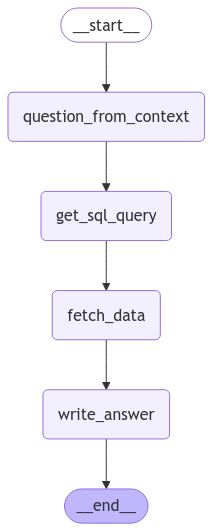

In [18]:
from IPython.display import display,Image
display(Image(agent.get_graph().draw_mermaid_png()))

In [19]:
response = agent.invoke({"user_query":"Which is the product having highest price and to which category that belongs to?"})
history = response["conv_history"]
print(response['output'])

The product with the highest price is "Côte de Blaye" and it belongs to the category of Beverages.


In [21]:
response = agent.invoke({"user_query":"Who is the supplier for that product?"})
print(response['output'])

I'm sorry, but without any SQL data provided, I am unable to determine the supplier for that product. Please provide the necessary SQL data for me to provide you with the answer.


##### since i'm maintaining the context in invocation thorugh state, state values are expiring, context needs to be maintained explicitly

In [22]:
response = agent.invoke({"user_query":"Which is the product having highest price and to which category that belongs to?"})
history = response["conv_history"]
print(response['output'])
print(history)

The product with the highest price is "Côte de Blaye" and it belongs to the category of "Beverages".
[{'user_query': 'Which is the product having highest price and to which category that belongs to?'}, {'answer': 'The product with the highest price is "Côte de Blaye" and it belongs to the category of "Beverages".'}]


##### here will collect the above conversation and pass it again to agent(adjusted in code), so it will be able to still give answer based on context

In [23]:
response = agent.invoke({"user_query":"Who is the supplier for that product?","conv_history":history})
print(response['output'])

The supplier for the product "Côte de Blaye" which belongs to the category of "Beverages" is "Aux joyeux ecclésiastiques".
